In [1]:
import pandas as pd
from src.utils.timescaledb_ops import TimescaleDBOps

# Technical Analysis and Chart

In [2]:
tsdb_ops = TimescaleDBOps()
columns, data = tsdb_ops.read_data("silver.ohlc_daily")
# columns, data = tsdb_ops.read_data("silver.ohlc_weekly")
# columns, data = tsdb_ops.read_data("silver.ohlc_monthly")
df = pd.DataFrame(data=data, columns=columns)
df = df.sort_values("date").reset_index(drop=True)
df["date"] = pd.to_datetime(df["date"])

2025-06-25 21:24:05,646 - INFO - Data read from silver.ohlc_daily successfully.


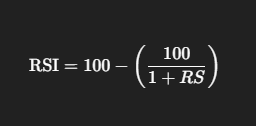

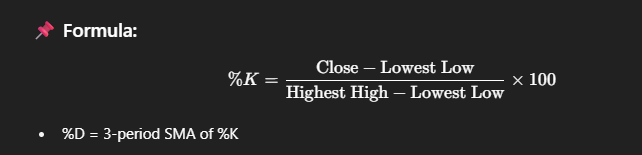

In [6]:
# Technical Analysis
# EMA
df['ema_13'] = df['close'].ewm(span=13, adjust=False).mean()
df['ema_21'] = df['close'].ewm(span=21, adjust=False).mean()

# # RSI
# window = 14 # default setting
# delta = df['close'].diff(1)
# avg_gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()  # avg_gain 
# avg_loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()
# rsi = avg_gain / avg_loss
# df['rsi'] = 100 - (100 / (1 + rsi)) 

# Stochastic
perc_k_length = 5
perc_k_smoothing = 3
perc_d_length = 3

lowest_low = df['low'].rolling(perc_k_length).min()
highest_high = df['high'].rolling(perc_k_length).max()
df["stochastic_%K"] = ((df['close'] -lowest_low) / (highest_high -lowest_low)).rolling(perc_k_smoothing).mean() 
df["stochastic_%D"] =  df["stochastic_%K"].rolling(perc_d_length).mean()

# MACD
ema_12 = df['close'].ewm(span=12, adjust=False).mean()
ema_26 = df['close'].ewm(span=26, adjust=False).mean()

macd = ema_12 - ema_26
macd_signal_line = macd.ewm(span=9, adjust=False).mean()
macd_bar = macd - macd_signal_line

df['macd'] = macd
df['macd_signal_line'] = macd_signal_line
df['macd_bar'] = macd_bar

## Technical Analysis

In [9]:
# Technical Analysis
# EMA
df['ema_13'] = df['close'].ewm(span=13, adjust=False).mean()
df['ema_21'] = df['close'].ewm(span=21, adjust=False).mean()

# Stochastic
window = 14 # default setting
perc_k_length = 5
perc_k_smoothing = 3
perc_d_length = 3

lowest_low = df['low'].rolling(window).min()
highest_high = df['high'].rolling(window).max()
df["stochastic_%K"] = ((df['close'] -lowest_low) / (highest_high -lowest_low)).rolling(perc_k_smoothing).mean() 
df["stochastic_%D"] =  df["stochastic_%K"].rolling(perc_d_length).mean()

# MACD
ema_12 = df['close'].ewm(span=12, adjust=False).mean()
ema_26 = df['close'].ewm(span=26, adjust=False).mean()

macd = ema_12 - ema_26
macd_signal_line = macd.ewm(span=9, adjust=False).mean()
macd_bar = macd - macd_signal_line

df['macd'] = macd
df['macd_signal_line'] = macd_signal_line
df['macd_bar'] = macd_bar

# LLM

In [2]:
from src.utils.timescaledb_ops import TimescaleDBOps
import pandas as pd
tsdb_ops = TimescaleDBOps()
columns, data = tsdb_ops.read_data("gold.ohlc_ta_weekly")
df = pd.DataFrame(data=data, columns=columns)
df = df.sort_values("date").reset_index(drop=True)
df["date"] = pd.to_datetime(df["date"])

2025-07-04 21:16:47,499 - INFO - Data read from gold.ohlc_ta_weekly successfully.


In [3]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

df_visualize = df[df['date'] >= '2024-01-01']

# Create subplot with 2 rows (OHLC and Volume)
fig = make_subplots(rows=4, cols=1, 
                    shared_xaxes=True, 
                    vertical_spacing=0.02,
                    row_heights=[0.6, 0.1, 0.15, 0.15],
                    subplot_titles=("OHLC BTC (USD)", "Volume", "Stochastic(5, 3, 3)", "MACD(12, 26, 9)"))

# ===================================================================
# PLOT CANDLESTICK
# ===================================================================
fig.add_trace(go.Candlestick(
    x=df_visualize['date'],
    open=df_visualize['open'],
    high=df_visualize['high'],
    low=df_visualize['low'],
    close=df_visualize['close'],
    name="Price",
    increasing_line_color='green',
    decreasing_line_color='red'
), row=1, col=1)


# ===================================================================
# PLOT VOLUME BAR
# ===================================================================
fig.add_trace(go.Bar(
    x=df_visualize['date'],
    y=df_visualize['volume'],
    name="Volume",
    marker_color='orange'
), row=2, col=1)


# ===================================================================
# PLOT EMA
# ===================================================================
fig.add_trace(
    go.Scatter(
        x=df_visualize['date'],
        y=df_visualize['ema_13'],
        mode='lines',
        name="EMA 13",
        line={'width': 1.5},
    ), row=1, col=1
)

fig.add_trace(
    go.Scatter(
        x=df_visualize['date'],
        y=df_visualize['ema_21'],
        mode='lines',
        name="EMA 21",
        line={'width': 1.5},
    ), row=1, col=1
)

# ===================================================================
# PLOT STOCHASTIC
# ===================================================================
fig.add_trace(
    go.Scatter(
        x=df_visualize['date'],
        y=df_visualize['stochastic_percentage_k'],
        mode='lines',
        name="Stochastic",
        line={'width': 1.5},
    ), row=3, col=1
)

fig.add_trace(
    go.Scatter(
        x=df_visualize['date'],
        y=df_visualize['stochastic_percentage_d'],
        mode='lines',
        name="Stochastic",
        line={'width': 1.5},
    ), row=3, col=1
)

# ===================================================================
# PLOT MACD
# ===================================================================
fig.add_trace(
    go.Scatter(
        x=df_visualize['date'],
        y=df_visualize['macd'],
        mode='lines',
        name="MACD Line",
        line={'width': 1.5},
    ), row=4, col=1
)

fig.add_trace(
    go.Scatter(
        x=df_visualize['date'],
        y=df_visualize['macd_signal_line'],
        mode='lines',
        name="MACD Signal Line",
        line={'width': 1.5},
    ), row=4, col=1
)

colors = ['green' if val >= 0 else 'red' for val in df_visualize['macd_bar']]
fig.add_trace(
    go.Bar(
        x=df_visualize['date'], 
        y=df_visualize['macd_bar'], 
        name='MACD Bar', 
        marker_color=colors
    ), row=4, col=1
)

# Layout adjustments
fig.update_layout(
    # title=title,
    xaxis_rangeslider_visible=False,
    template='plotly_dark',
    height=1000,
    margin=dict(l=50, r=25, t=50, b=40)
)

fig.write_image("btc_monthly_ta.jpeg", width=1200, height=800, scale=2)

In [83]:
import json
message = json.loads(llm_output.content[0].text)

summary = ""
summary += f"Action: **{message['action'].capitalize()}**\n"
for num, (indicator, explanation) in enumerate(message['reason'].items()):
    summary += f"{num+1}. **{indicator.upper()}**: {explanation}.\n"
summary += "*^Disclaimer Alert.*"

# Send to Discord Channel

In [89]:
import requests

webhook_url = "https://discordapp.com/api/webhooks/1387080438140637184/tN2QiS7fsMTOpf9eHQAF8cb2xfAscck9R6qhKq-hvvg4Ssg0YfHsSXvGIDLZUchoFQ6V"
granularity = "Weekly"

embed = {
    "title": f"**Bitcoin (BTC-USD) {granularity.capitalize()} Summary**",
    "image": {"url": "attachment://btc_monthly_ta.jpeg"},
    "description": summary,
    "color": 5814783  # optional: light blue
}
data = {
    "content": (
        f"**Bitcoin (BTC-USD) {granularity.capitalize()} Summary**\n\n"
        f"{summary}"
    )
}


files = {
    "file": (
        "btc_monthly_ta.jpeg", 
        open("C:/Users/USER/projects/ai-agent-crypto-analyzer/notebooks/btc_monthly_ta.jpeg", "rb")
    )
}

# Use `data=` for data when uploading files
response = requests.post(webhook_url, files=files, data=data)

# Using Langchain Anthropic

In [7]:
from src.utils.timescaledb_ops import TimescaleDBOps
import pandas as pd
pair = "XXBTZUSD"
timeframe = "weekly"
start_date = "2024-01-01"
tsdb_ops = TimescaleDBOps()
columns, data = tsdb_ops.read_data(f"gold.ohlc_ta_{timeframe}")
df = pd.DataFrame(data=data, columns=columns)
df["date"] = pd.to_datetime(df["date"])
df = df[df['pair'] == pair]
df = df[df["date"] >= start_date]
df = df.sort_values("date").reset_index(drop=True)

2025-07-04 21:17:22,257 - INFO - Data read from gold.ohlc_ta_weekly successfully.
INFO	ai-agent-crypto-analyzer:timescaledb_ops.py:read_data()- Data read from gold.ohlc_ta_weekly successfully.


In [8]:
# Import Credentials
import os
import getpass
from dotenv import load_dotenv

load_dotenv()

True

In [9]:
from enum import Enum
from pydantic import BaseModel, Field
from langchain_core.output_parsers import PydanticOutputParser

class Actions(Enum):
    WEAK_SELL = 'Weak Sell'
    SELL = 'Sell'
    STRONG_SELL = 'Strong Sell'
    WEAK_BUY = 'Weak Buy'
    BUY = 'Buy'
    STRONG_BUY = 'Strong Buy'


class AnalysisResponse(BaseModel):
    actions: Actions = Field(description="Actions to take based on the technical analysis")
    reasons: dict[str, str] = Field(description="Key-Value pair where the key is the technical indicator and the values is the analysis based on the technical indicator.")

parser = PydanticOutputParser(pydantic_object=AnalysisResponse)

In [10]:
# Get data from database
from src.utils.timescaledb_ops import TimescaleDBOps
import pandas as pd

# Construct the image base64 string
# 1. Create png image
import plotly.graph_objects as go
from plotly.subplots import make_subplots

df_visualize = df[df['date'] >= '2022-01-01']

# Create subplot with 2 rows (OHLC and Volume)
fig = make_subplots(rows=4, cols=1, 
                    shared_xaxes=True, 
                    vertical_spacing=0.02,
                    row_heights=[0.6, 0.1, 0.15, 0.15],
                    subplot_titles=("OHLC BTC (USD)", "Volume", "Stochastic(5, 3, 3)", "MACD(12, 26, 9)"))

# ===================================================================
# PLOT CANDLESTICK
# ===================================================================
fig.add_trace(go.Candlestick(
    x=df_visualize['date'],
    open=df_visualize['open'],
    high=df_visualize['high'],
    low=df_visualize['low'],
    close=df_visualize['close'],
    name="Price",
    increasing_line_color='green',
    decreasing_line_color='red'
), row=1, col=1)


# ===================================================================
# PLOT VOLUME BAR
# ===================================================================
fig.add_trace(go.Bar(
    x=df_visualize['date'],
    y=df_visualize['volume'],
    name="Volume",
    marker_color='orange'
), row=2, col=1)


# ===================================================================
# PLOT EMA
# ===================================================================
fig.add_trace(
    go.Scatter(
        x=df_visualize['date'],
        y=df_visualize['ema_13'],
        mode='lines',
        name="Exponential Moving Averages 13",
        line={'width': 1.5},
    ), row=1, col=1
)

fig.add_trace(
    go.Scatter(
        x=df_visualize['date'],
        y=df_visualize['ema_21'],
        mode='lines',
        name="Exponential Moving Averages 21",
        line={'width': 1.5},
    ), row=1, col=1
)

# ===================================================================
# PLOT STOCHASTIC
# ===================================================================
fig.add_trace(
    go.Scatter(
        x=df_visualize['date'],
        y=df_visualize['stochastic_percentage_k'],
        mode='lines',
        name="Stochastic %K",
        line={'width': 1.5},
    ), row=3, col=1
)

fig.add_trace(
    go.Scatter(
        x=df_visualize['date'],
        y=df_visualize['stochastic_percentage_d'],
        mode='lines',
        name="Stochastic %D",
        line={'width': 1.5},
    ), row=3, col=1
)

# ===================================================================
# PLOT MACD
# ===================================================================
fig.add_trace(
    go.Scatter(
        x=df_visualize['date'],
        y=df_visualize['macd'],
        mode='lines',
        name="MACD Line",
        line={'width': 1.5},
    ), row=4, col=1
)

fig.add_trace(
    go.Scatter(
        x=df_visualize['date'],
        y=df_visualize['macd_signal_line'],
        mode='lines',
        name="MACD Signal Line",
        line={'width': 1.5},
    ), row=4, col=1
)

colors = ['green' if val >= 0 else 'red' for val in df_visualize['macd_bar']]
fig.add_trace(
    go.Bar(
        x=df_visualize['date'], 
        y=df_visualize['macd_bar'], 
        name='MACD Bar', 
        marker_color=colors
    ), row=4, col=1
)

# Layout adjustments
fig.update_layout(
    # title=title,
    xaxis_rangeslider_visible=False,
    template='plotly_dark',
    height=1000,
    margin=dict(l=50, r=25, t=50, b=40)
)
fig.show()
fig.write_image(f"btc_{timeframe}_ta.png", width=1200, height=800, scale=2)

In [13]:
import base64
def get_base64_encoded_image(image_path):
    with open(image_path, "rb") as image_file:
        binary_data = image_file.read()
        base64_encoded_data = base64.b64encode(binary_data)
        base64_string = base64_encoded_data.decode("utf-8")
        return base64_string

image_base64 = get_base64_encoded_image(f"btc_{timeframe}_ta.png")

In [14]:
from langchain_core.prompts import ChatPromptTemplate
from langchain_anthropic import ChatAnthropic
from abc import ABC, abstractmethod

class LLMStrategy(ABC):
    @abstractmethod
    def analyze(self, prompt_template: ChatPromptTemplate, image_base64: str, pair: str, timeframe: str) -> AnalysisResponse:
        pass

class LLMAnalyzerInterface():
    # Define constructore
    
    def __init__(self, llm_strategy: LLMStrategy):
        self.__llm_strategy = llm_strategy
    
    # Define setters and getters
    @property
    def llm_strategy(self):
        return self.__llm_strategy
    
    @llm_strategy.setter
    def set_llm_strateg(self, llm_strategy: LLMStrategy):
        self.__llm_strategy = llm_strategy
    
    # Define abstract method for analysis
    def analyze(self, prompt_template: ChatPromptTemplate, image_base64: str, pair: str, timeframe: str) -> AnalysisResponse:
        return self.llm_strategy.analyze(
            prompt_template=prompt_template,    
            image_base64=image_base64,
            pair=pair, 
            timeframe=timeframe
        )

class AnthropicLLMStrategy(LLMStrategy):
    def __init__(self, **kwargs):
        super().__init__()
        self.__llm = ChatAnthropic(
            **kwargs
        ).with_structured_output(AnalysisResponse)
    
    def analyze(self, prompt_template: ChatPromptTemplate, image_base64: str, pair: str, timeframe: str):
        chain = prompt_template | self.__llm
        return chain.invoke(
        {
            "image_base64": image_base64,
            "pair": pair,
            "timeframe": timeframe,
            "actions" : "\n".join(f"{num+1}. {action.value}" for num, action in enumerate(Actions)),
        }
    )



        

In [ ]:
from enum import Enum
from pydantic import BaseModel, Field
from langchain_core.output_parsers import PydanticOutputParser

class Actions(Enum):
    WEAK_SELL = 'Weak Sell'
    SELL = 'Sell'
    STRONG_SELL = 'Strong Sell'
    WEAK_BUY = 'Weak Buy'
    BUY = 'Buy'
    STRONG_BUY = 'Strong Buy'



class AnalysisResponse(BaseModel):
    actions: Actions = Field(description="Provide actions to take based on the technical analysis")
    reasons: dict[str, str] = Field(description="Provide the technical indicators used as a key and the analysis based on technical indicators as a value")


# Get Anthropic LLM Model
# from langchain_anthropic import ChatAnthropic
llm_analyzer = LLMAnalyzerInterface(
    AnthropicLLMStrategy(
        model="claude-sonnet-4-20250514",
        max_tokens=20000,
        temperature=0,
        timeout=None,
        max_retries=2
    )
)

# Construct the prompt
from langchain_core.prompts import ChatPromptTemplate
chat_prompt_template = ChatPromptTemplate(
    [
        {
            "role": "system", 
            "content": [
                {
                    "type": "text",
                    "text": "You are a professional cryptocurrency trader at a top proprietary trading firm, specializing in technical analysis."
                }
            ]
        },
        {
            "role": "user",
            "content": [
                {
                    "type": "image",
                    "source_type": "base64",
                    "mime_type": "image/png",
                    "data": "{image_base64}",
                },
                {
                    "type": "text",
                    "text": (
                        "Your task is to analyze the {timeframe} chart and technical indicators for {pair} based on the provided image. "
                        "Perform a technical analysis based on candlestick charts, and technical indicators shown in image. "
                        "Your technical analysis should lead to a recommendation one of the following actions:\n"
                        "{actions}"
                    )
                }
            ]
        }
    ],
    input_variables = ["timeframe", "pair", "actions", "image_base64"],
)

chat_prompt_template.format_messages(
    image_base64= image_base64,
    pair= pair,
    timeframe= timeframe,
    actions = "\n".join(f"{num+1}. {action.value}" for num, action in enumerate(Actions)),
    technical_indicators= "EMA, Stochastic, MACD"
)

In [ ]:
response = llm_analyzer.analyze(
    prompt_template = chat_prompt_template,
    image_base64 = image_base64,
    pair = pair,
    timeframe = timeframe,
)

In [92]:
import json
summary = ""
summary += f"Action: **{response.actions.value}**\n"
for num, (indicator, explanation) in enumerate(response.reasons.items()):
    summary += f"**{indicator}**\n{explanation}.\n\n"
summary += "*^Disclaimer Alert.*"

In [93]:
print(summary)

Action: **Weak Sell**
**Price Action**
BTC is trading near the top of its recent range around $110k after a strong uptrend. The current candle shows a red body with upper wick, indicating selling pressure at these elevated levels and potential rejection of higher prices..

**Exponential Moving Averages**
Price is trading above both EMA 13 (teal) and EMA 21 (purple), confirming the overall uptrend remains intact. However, the EMAs are starting to flatten, suggesting momentum may be slowing..

**Stochastic Oscillator**
The Stochastic (5,3,3) is showing %K and %D lines in the lower portion of the range around 0.4-0.5 level, indicating the asset is not in overbought territory but momentum appears to be weakening from previous highs..

**MACD**
The MACD line appears to be converging with the signal line near the zero level, with the histogram showing mixed red and green bars. This suggests weakening bullish momentum and potential for a bearish crossover..

**Volume**
Volume appears to be de

In [94]:
import requests

webhook_url = "https://discordapp.com/api/webhooks/1387080438140637184/tN2QiS7fsMTOpf9eHQAF8cb2xfAscck9R6qhKq-hvvg4Ssg0YfHsSXvGIDLZUchoFQ6V"
granularity = "Weekly"

embed = {
    "title": f"**Bitcoin (BTC-USD) {granularity.capitalize()} Summary**",
    "image": {"url": "attachment://btc_monthly_ta.png"},
    "description": summary,
    "color": 5814783  # optional: light blue
}
data = {
    "content": (
        f"**Bitcoin (BTC-USD) {granularity.capitalize()} Summary**\n\n"
        f"{summary}"
    )
}


files = {
    "file": (
        "btc_monthly_ta.png", 
        open("C:/Users/USER/projects/ai-agent-crypto-analyzer/notebooks/btc_monthly_ta.png", "rb")
    )
}

# Use `data=` for data when uploading files
requests.post(webhook_url, files=files, data=data)

<Response [200]>